# ユーティリティー・スケール実験 I

<Admonition type="note">
  Tamiya Onodera (5 July 2024)
  Translated by Ryuki Tachibana

  [Download the pdf](https://ibm.box.com/shared/static/k38xhk5yaqy9b3gjdmu0ynhnd9i4c3e1.zip) が元々の講義資料です。日本語版の講義資料は[こちら](12_utility_1.pdf)です。Qiskitの更新によって、コード・サンプルの中には今では非推奨となった機能を使っているものがあるかもしれないことをご容赦ください。

  *この実験を実行するのに使われる QPU時間はおよそ45秒です。*
</Admonition>



## 1. ユーティリティー論文へのいざない

このノートブックを使ったレッスンでは、私たちが ["ユーティリティー論文"](https://www.nature.com/articles/s41586-023-06096-3)と呼んでいる、Nature Vol 618 (2023/6/15)に掲載された論文で利用された、ユーティリティー・スケール（実用規模）の量子回路を走らせます。この論文は2次元の横磁場イジングモデルの時間発展を扱います。特に扱われるのは、次のような形式のハミルトニアンです。

$$
H = H_{ZZ} + H_X = - J \sum_{(i,j)} Z_i Z_j + h \sum_{i} X_i
$$

ここで、 $i < j$ であり、 $J > 0$ は最近傍のスピンとのスピン結合定数、$h$ は大局的な横磁場の強さを表す係数です。

この論文では、この時間発展演算子の、次のような一次トロッター分解を用いて、初期状態からの時間変化をシミュレーションしました。

$$
\begin{aligned}
 \exp(-i H_{ZZ} \delta t) &= \prod_{(i,j)} \exp (i J \delta t Z_i Z_j)  = \prod_{(i,j)} \mathrm{R}_{Z_i Z_j} ( - 2 J \delta t) \\
 \exp(-i H_X \delta t) &= \prod_{i} \exp (-i h \delta t X_i )  = \prod_{i} \mathrm{R}_{X_i} ( 2 h \delta t)
\end{aligned}
$$

ここで、時間間隔 $T$ は $T / \delta t$ 回のTrotterステップに離散化されています。$\mathrm{R}_{Z_i Z_j}(\theta_J)$ と $\mathrm{R}_{X_i}(\theta_h)$
はそれぞれ $ZZ$ と $X$ 回転ゲートです。

そして、ヘビーヘックス構造で互いに接続された 127量子ビットを持つ IBM Quantum® Eagleプロセッサー上で実験を行いました。この実験ではすべての量子ビットに $X$ゲートを、そして直接接続された量子ビットのすべてのペアに $ZZ$ インタラクションを適用しました。

ここで、「データの依存性」があるために、すべてのペアに $ZZ$ インタラクションを同時に適用することはできません。そのため、**量子ビットのペアを色分けし**、いくつかのグループに分けました。同じグループに入れられたペアには同じ色が割り当てられていて、同時に $ZZ$ ゲートを適用されます。

加えて、実験の単純化のためにこの論文では $\theta_J=-\pi /2$ のケースに絞りました。

この論文の新規性ある価値は、古典コンピューター上でソフトウェア的に実行される statevectorシミュレーションの規模を超えた量子回路を構築し、ノイズが生じる量子コンピューターの実機で実際に実行し、そして信頼できる結果を得ることに成功したというところにあります。言い換えれば、ノイズの生じる量子コンピューターの実用性を実証したということです。これを実行するにあたって、彼らはノイズによって生じる誤差を緩和/補正するために、zero-noise extrapolation (ZNE) と probabilistic error amplification (PEA) というエラー緩和手法を利用しました。

この論文以降、このような手法と規模を持った実験を私たちは、ユーティリティー・スケール（実用規模）の実験と呼んでいます。



### 1.1 目標

このレッスンの目標は、ユーティリティー・スケールの量子回路を作り、Eagleプロセッサー上で実行することです。信頼性のある結果を得るというところまではこのノートブックの範囲では扱わないことにします。これは、このノートブックを最初に執筆した時点でPEAが Qiskitでまだ実験段階にあったことと、PEAやZNEの適用にはかなりの時間がかかることが理由です。

具体的に目標を述べると、論文の図4bに対応する量子回路の構築と実行を行なって、このグラフで "unmitigated"（エラー緩和なし）と表示されている点を計算してプロットします。これらは、127量子ビット $\times$ 60レイヤー（20トロッター・ステップ）の規模で、$\langle Z_{62} \rangle$ をオブザーバブルとして利用する量子回路です。

![image.png](utility1.avif)


難しそうでしょうか？ 心配は不要です。これまでの過去3回のレッスンがヒントになります。まず、27量子ビット $\times$ 6レイヤー（2トロッター・ステップ）という小さな規模で、 $\langle Z_{13} \rangle$をオブザーバブルとして使う量子回路を構築し、実機ではなくシミュレーションされたデバイスで実行してみましょう。

前置きは以上としまして、ユーティリティー・スケールの冒険に出発してみましょう！


In [1]:
import qiskit

qiskit.__version__

'2.1.0'

In [2]:
#!pip install qiskit_ibm_runtime
#!pip install qiskit_aer

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import rustworkx as rx

from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter
from qiskit.circuit.library import YGate
from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime import (
    QiskitRuntimeService,
    fake_provider,
    EstimatorV2 as Estimator,
)
from qiskit_aer import AerSimulator

In [4]:
service = QiskitRuntimeService()

In [5]:
# token = "Sx2HlV3tqdCeLmE7HJd7TfMoDCWg3ybaR6srB7jYIOx5"

In [ ]:
# from qiskit_ibm_runtime import QiskitRuntimeService
 
# QiskitRuntimeService.save_account(
#  token=token,
#  channel="ibm_quantum_platform", # `channel` distinguishes between different account types.
#  instance="crn:v1:bluemix:public:quantum-computing:us-east:a/aa261b51b545de31d6dcf44505bc716a:ac6a1f88-6ae2-4e25-9afa-46d256e465b3::", # Optionally copy the instance CRN or name from the Instance section on the dashboard.
#  name="upgraded IQP", # Optionally name this set of credentials.
#  overwrite=True # Only needed if you already have Cloud credentials.
# )

## 2. 準備

### 2.1 RZZ(-$\pi$ / 2)ゲートの作成

まず、一般的なRZZゲートの実行には 2つの$CX$ゲートが必要になることを見てみましょう。



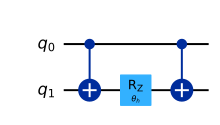

In [13]:
from qiskit.circuit.library import RZZGate

θ_h = Parameter("$\\theta_h$")
qc1 = QuantumCircuit(2)
qc1.append(RZZGate(θ_h), [0, 1])
qc1.decompose(reps=1).draw("mpl")

前述したように、今回の実験は特定の回転角（-$\pi$ / 2）の RZZゲートだけを用います。この論文の中でも示されています通り、その場合に限れば RZZゲートは $CX$ゲート 1つで実装できます。

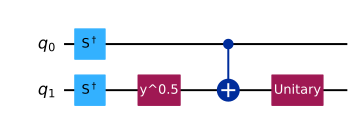

In [14]:
qc2 = QuantumCircuit(2)

qc2.sdg([0, 1])
qc2.append(YGate().power(1 / 2), [1])
qc2.cx(0, 1)
qc2.append(YGate().power(1 / 2).adjoint(), [1])

qc2.draw("mpl")

あとでこの回路を使えるように、これをゲートとして定義しておきます。



In [15]:
rzz = qc2.to_gate(label="RZZ")

こうして作った `rzz` ゲートは、たとえば次のように任意の回路の中で使うことができます。



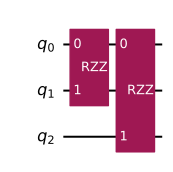

In [16]:
qc3 = QuantumCircuit(3)
qc3.append(rzz, [0, 1])
qc3.append(rzz, [0, 2])
display(qc3.draw("mpl"))
# display(qc.decompose(reps=1).draw("mpl"))

これを実際に目的の回路の中で使う前に、-$\pi$ / 2 をRZZGateにパラメーターとして与えた場合 `qc1` と、自分で定義した `rzz` を使った場合 `qc2` が理論的に一致していることを確かめておきます。


In [17]:
from qiskit.quantum_info import Operator

op1 = Operator(qc1.assign_parameters([-np.pi / 2]))
op2 = Operator(qc2)

op1.equiv(op2)

True

### 2.2 カップリング・マップの色分け

バックエンド（QPU）のカップリング・マップを色分けする方法をやってみましょう。これは今回の目標回路で使う $ZZ$インタラクションをグループ分けするのに必要になります。

手始めに、まずバックエンドのカップリング・マップを視覚化してみます。現時点でサービス提供している IBM Quantumデバイスのカップリング・マップはすべてヘビーヘックス構造を持っています。



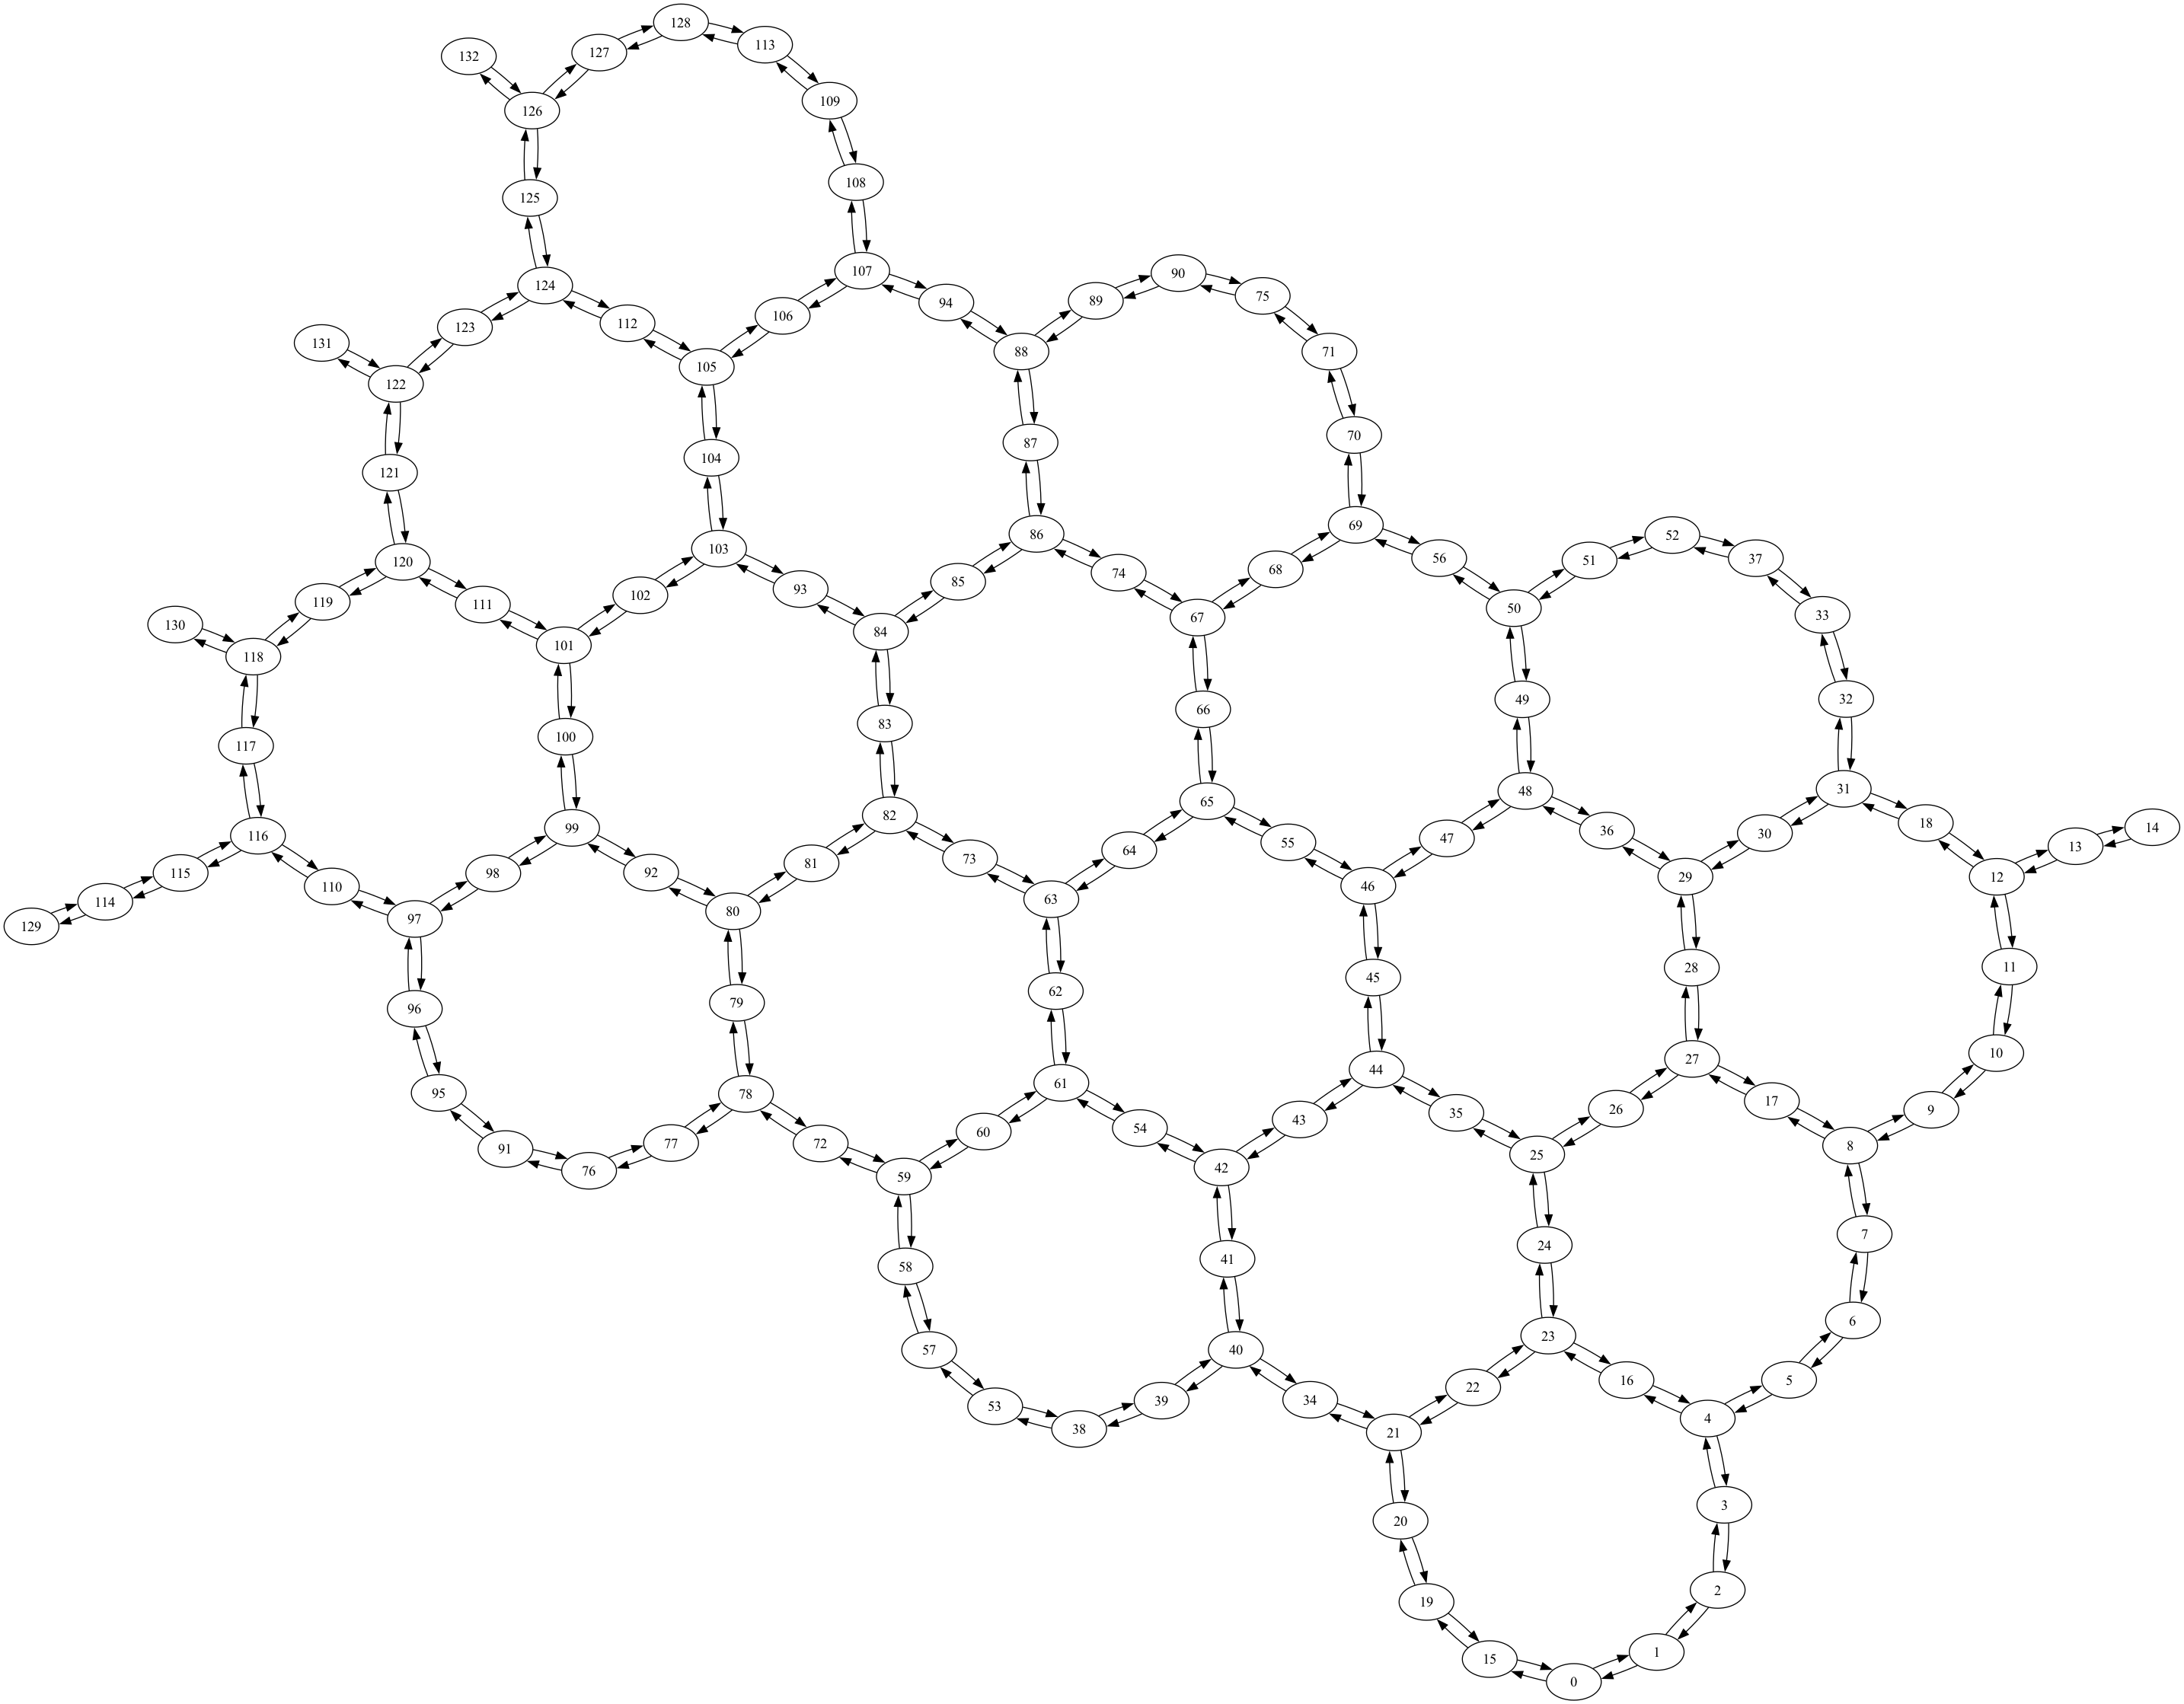

In [18]:
backend = service.least_busy(operational=True, simulator=False)

backend.coupling_map.draw()

カップリング・マップの色分けにここでは [rustworkx](https://www.rustworkx.org/) を使います。これは、グラフや複雑なネットワーク構造を扱うための Pythonパッケージです。このパッケージは色分けアルゴリズムを複数提供しています。ただし、それらはヒューリスティクスに基づくものであって、必ずしも最小色分け解を見つけることが保証されているわけではないことにご注意ください。

一般論としてはそうではありますが、私たちが扱うヘビーヘックスのグラフは 2部グラフであるので、[graph\_bipartite\_edge\_color](https://www.rustworkx.org/apiref/rustworkx.graph_bipartite_edge_color.html) を使えば最小色分け解が得られるはずです。



In [19]:
def color_coupling_map(backend):
    graph = backend.coupling_map.graph
    undirected_graph = graph.to_undirected(multigraph=False)
    edge_color_map = rx.graph_bipartite_edge_color(undirected_graph)
    if edge_color_map is None:
        edge_color_map = rx.graph_greedy_edge_color(undirected_graph)
    # build a map from color to a list of edges
    edge_index_map = undirected_graph.edge_index_map()
    color_edges_map = {color: [] for color in edge_color_map.values()}
    for edge_index, color in edge_color_map.items():
        color_edges_map[color].append(
            (edge_index_map[edge_index][0], edge_index_map[edge_index][1])
        )
    return edge_color_map, color_edges_map

ヘビーヘックスのグラフは一般に3色で色分けができるはずです。このことを先に視覚化したカップリング・マップで確認してみましょう。



In [20]:
edge_color_map, color_edges_map = color_coupling_map(backend)
print(
    f"{backend.name}, {backend.num_qubits}-qubit device, {len(color_edges_map.keys())} colors assigned."
)

ibm_torino, 133-qubit device, 3 colors assigned.


確認できましたね。

参考までに、得られた色分けで、この rustworkxの視覚化機能を使ってカップリング・マップを実際に色分けしてみましょう。


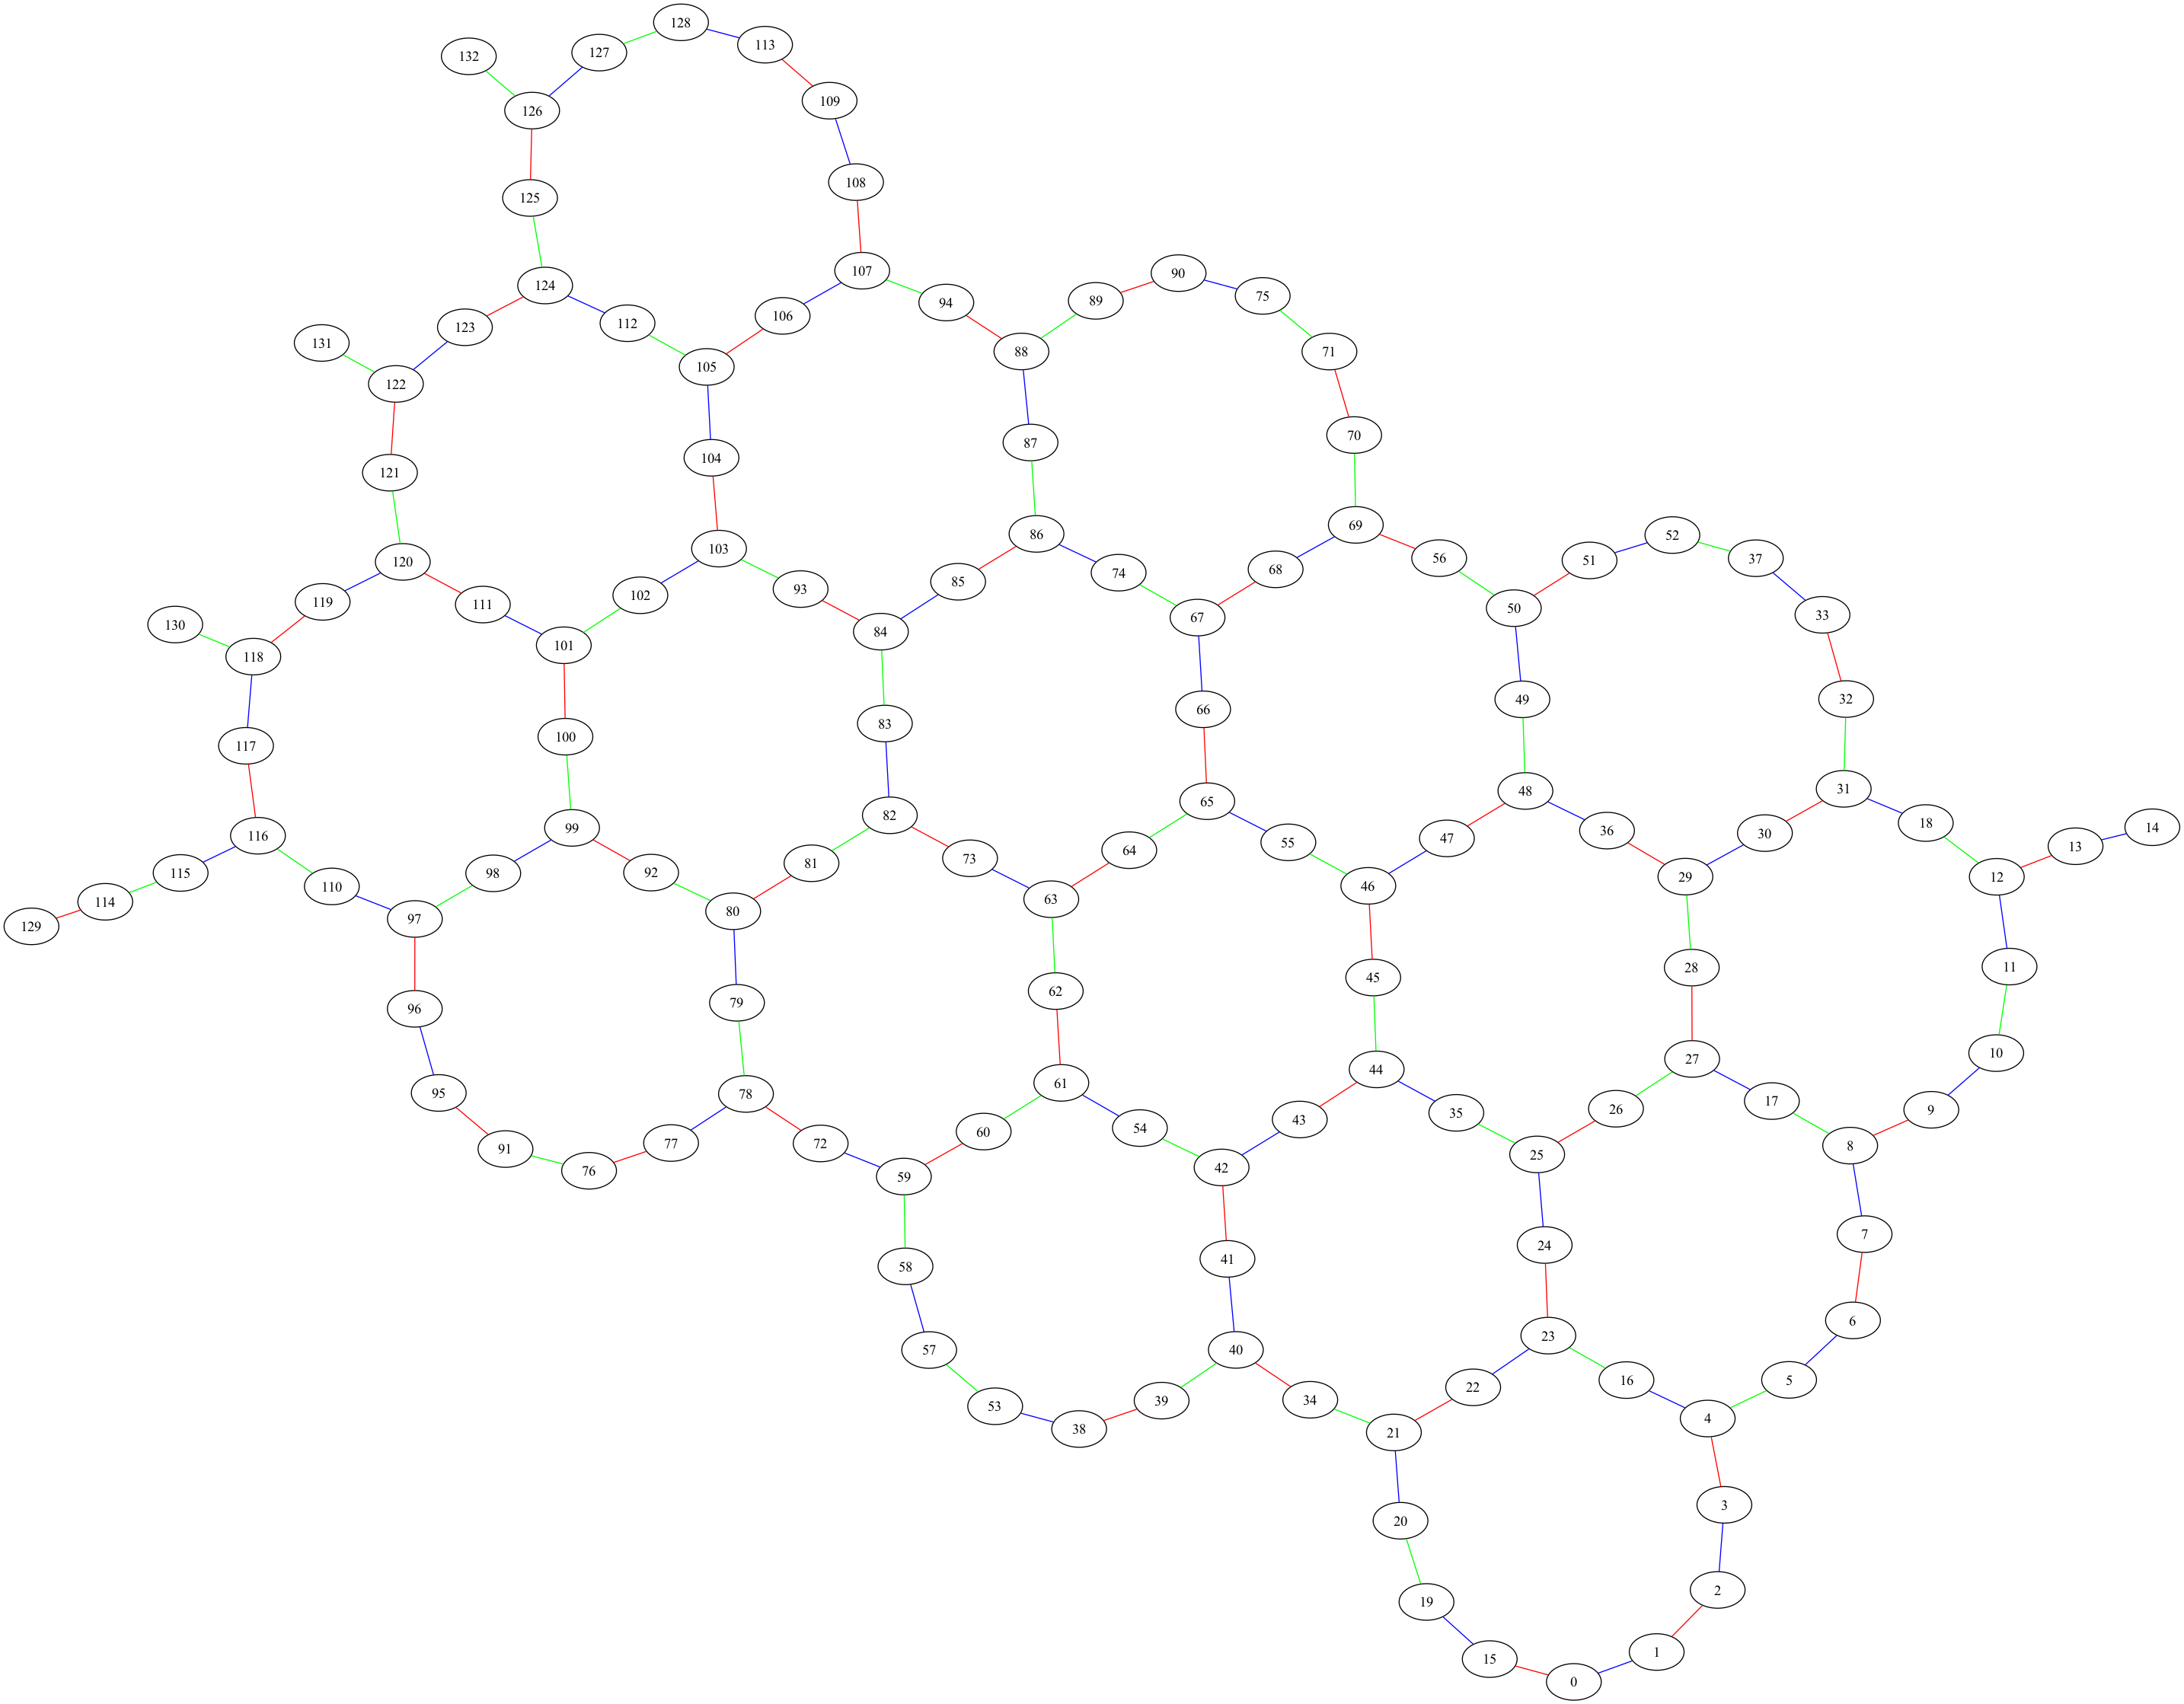

In [21]:
color_str_map = {0: "green", 1: "red", 2: "blue"}

undirected_graph = backend.coupling_map.graph.to_undirected(multigraph=False)
for i in undirected_graph.edge_indices():
    undirected_graph.get_edge_data_by_index(i)["color"] = color_str_map[
        edge_color_map[i]
    ]

rx.visualization.graphviz_draw(
    undirected_graph, method="neato", edge_attr_fn=lambda edge: {"color": edge["color"]}
)

## 3. 2次元イジングモデルのトロッター分解を用いた時間発展

次に、このユーティリティー論文で 2次元イジング・モデルの時間発展のために使われている量子回路を構築するサブルーチンを定義します。サブルーチン化するのは、何度も同じ回路を作る必要があったり、パラメーターを変えた違うバージョンの回路を作る必要があったりするからです。このサブルーチンは、3つのパラメーターを引数として受け取ります。バックエンド backend、トロッター・ステップ数を表す整数 num_steps、そして、バリアの挿入を制御するためのブール値 barrier です。


In [22]:
def get_utility_circuit(backend, num_steps: int, barrier: bool = False):
    num_qubits = backend.num_qubits
    _, color_edges_map = color_coupling_map(backend)
    θ_h = Parameter("$\\theta_h$")
    qc = QuantumCircuit(num_qubits)

    for i in range(num_steps):
        qc.rx(θ_h, range(num_qubits))

        for _, edge_list in color_edges_map.items():
            for edge in edge_list:
                qc.append(rzz, edge)

        if barrier:
            qc.barrier()
    return qc

この先で注意していただきたいのは、私たちは先の色分けを使って量子ビットのマッピングとルーティングを手作業で済ませるつもりであるということです。ですので、ここで構築した量子回路をトランスパイルするときには、トランスパイラに量子ビットのマッピングやルーティングをさせませんし、**させない方が良いです** 。あとでコードに実演しますが、そのような制御は、optimization levelを1にして、layout methodを "trivial" にすれば可能です。

さて次に、構築した回路についての情報を簡単にチェックするためのちょっとしたサブルーチンを定義しておきます。


In [23]:
def get_circuit_info(qc: QuantumCircuit, reps: int = 0):
    qc0 = qc.decompose(reps=reps)
    return (
        f"{qc0.num_qubits} qubits × {qc0.depth(lambda x: x.operation.num_qubits == 2)} layers ({qc0.depth()}-depth)"
        + ",  "
        + f"""Gate breakdown: {", ".join([f"{k.upper()} {v}" for k, v in qc0.count_ops().items()])}"""
    )

これらのサブルーチンを実行してみましょう。FakeTrontoというフェイク・デバイス（シミュレーションされたQPU）を使った以下の手続きでは、27量子ビット $\times$ 15レイヤー（5 トロッター・ステップ）の回路が表示されるはずです。このフェイク・デバイス（FakeTronto）には 28本のエッジがありますので、構築した量子回路には量子もつれを生じさせる 28 $\times$ 5 個の2量子ビット・ゲートが含まれるはずです。


/Users/ryuki/work/qenv202506/lib/python3.13/site-packages/qiskit/visualization/circuit/matplotlib.py:270: UserWarning: Style JSON file 'default.json' not found in any of these locations: /Users/ryuki/work/qenv202506/lib/python3.13/site-packages/qiskit/visualization/circuit/styles/default.json, ~/default.json, ~/.qiskit/default.json, default.json. Will use default style.
  self._style, def_font_ratio = load_style(


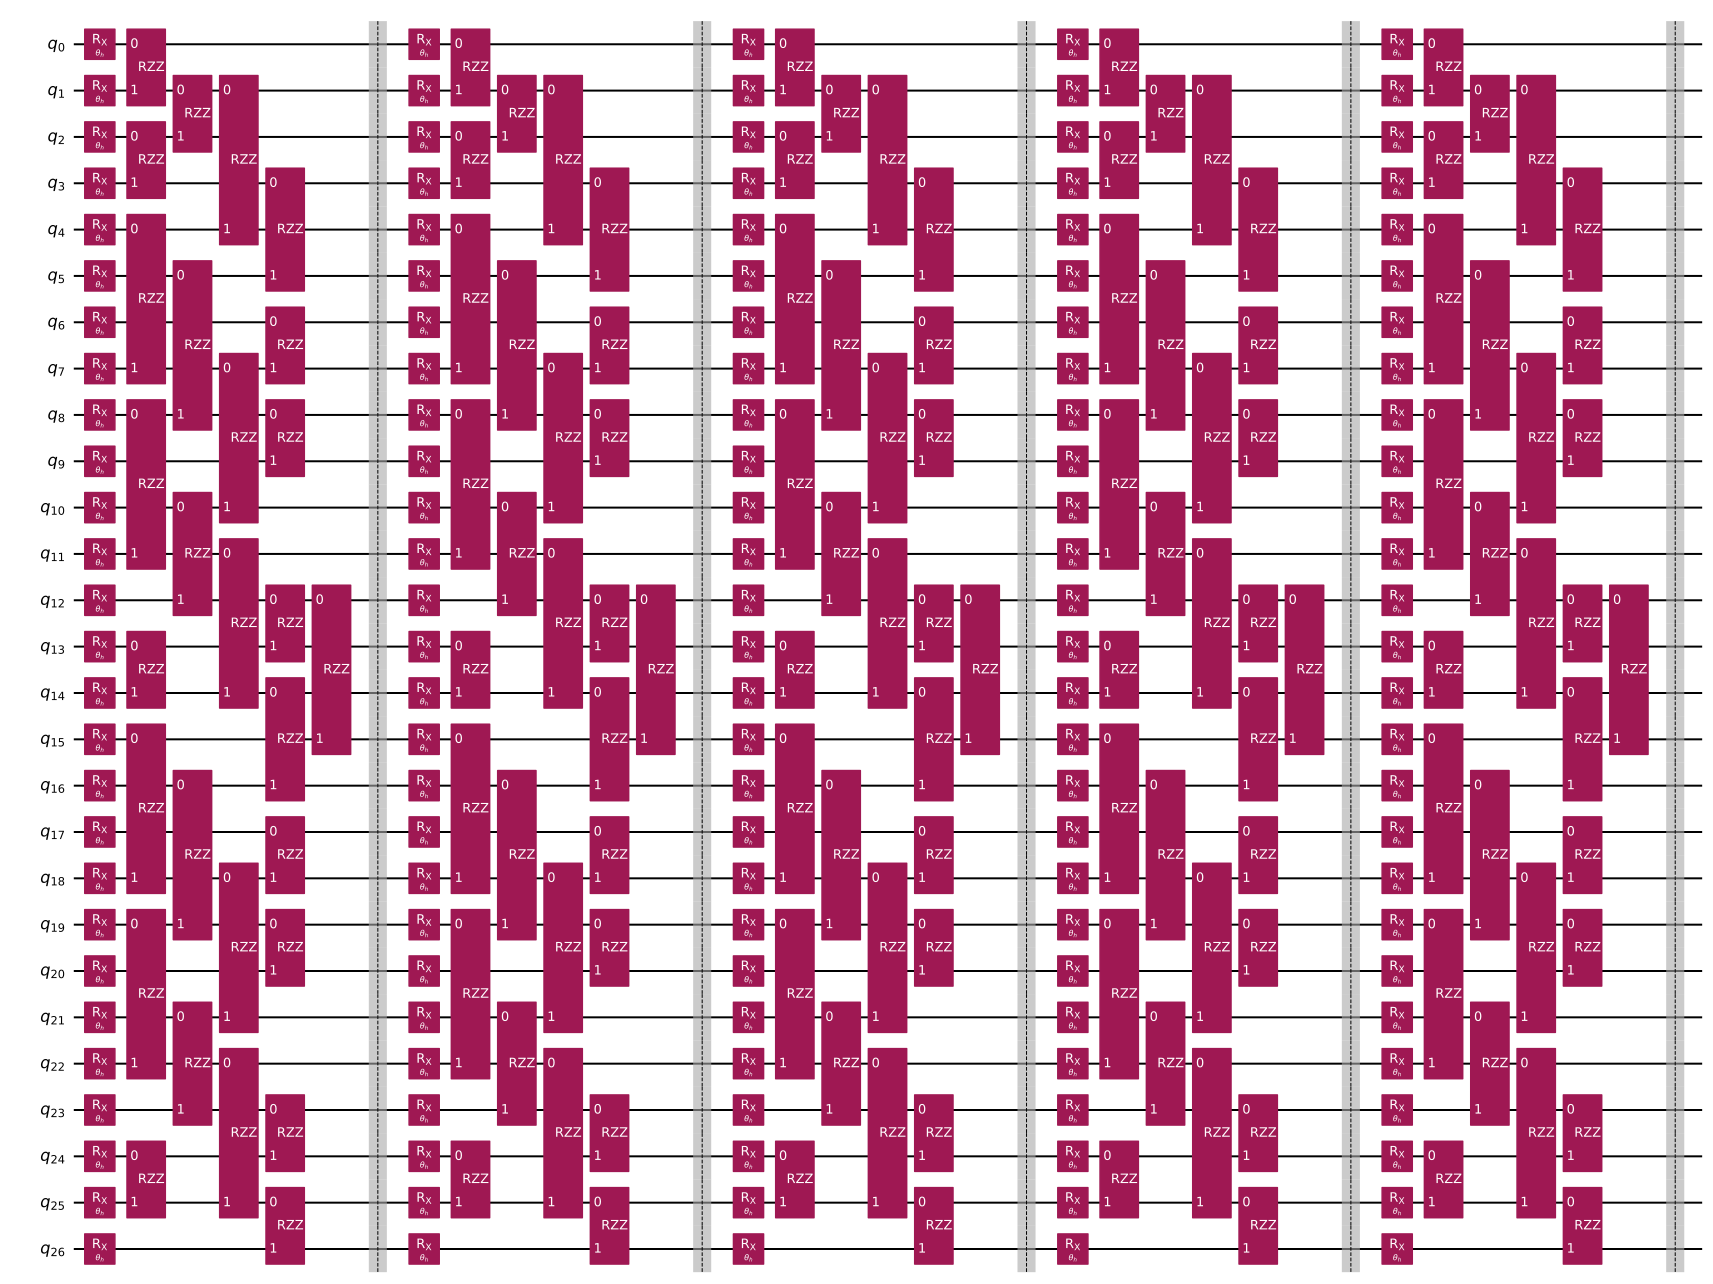

27 qubits × 15 layers (20-depth),  Gate breakdown: CIRCUIT-177 140, RX 135, BARRIER 5
27 qubits × 15 layers (60-depth),  Gate breakdown: SDG 280, UNITARY 280, CX 140, R 135, BARRIER 5


In [24]:
backend = fake_provider.FakeTorontoV2()
num_steps = 5
qc = get_utility_circuit(backend, num_steps, True)

display(qc.draw(output="mpl", fold=-1))
print(get_circuit_info(qc, reps=0))
print(get_circuit_info(qc, reps=1))

## 4. 27量子ビットの規模でこの問題を解いてみる

ここではまずユーティリティー実験を縮小版で実演してみます。具体的には、27量子ビット $\times$ 6レイヤー（2トロッター・ステップ）の規模で、$\langle Z_{13} \rangle$ をオブザーバブルとして使用する量子回路を構築し、AerSimulatorとフェイク・デバイスのそれぞれで実行してみます。

それをする際には、もちろん「Qiskitパターン」の 4ステップに従います。すなわち、Map、Optimize、Execute、Post-Processです。それぞれの役割は次のとおりです。

*   古典入力を量子計算にマッピング（Map）します。
*   量子計算のための回路を最適化（Optimize）します。
*   プリミティブを使って回路を実行（Execute）します。
*   得られた結果を後処理（Post-process）して、古典データのフォーマットで返します。

以下ではまず、この小規模実験のための回路を構築して問題を Mapします。その次に、AerSimulatorとフェイク・デバイスのそれぞれについて、Optimizeと Executeを行います。最後に、結果をプロットするという Post-Processを行います。



### 4.1 ステップ1: Map



In [26]:
backend = fake_provider.FakeTorontoV2()  # a 27 qubit fake device.
num_steps = 2
qc = get_utility_circuit(backend, num_steps)
obs = SparsePauliOp.from_sparse_list(
        [("Z", [13], 1)], num_qubits=backend.num_qubits
    )  # Falcon
angles = [
    0,
    0.1,
    0.2,
    0.3,
    0.4,
    0.5,
    0.6,
    0.7,
    0.8,
    1.0,
    np.pi / 2,
]  # We try 11 angles for theta_h.

### 4.2 ステップ 2 および 3: Optimize と Execute (Aerシミュレーターを使用)



In [27]:
backend_sim = AerSimulator()
transpiled_qc_sim = transpile(
    qc, backend_sim, optimization_level=1, layout_method="trivial"
)
transpiled_obs_sim = obs.apply_layout(layout=transpiled_qc_sim.layout)

print(get_circuit_info(qc, reps=1))
print(get_circuit_info(transpiled_qc_sim, reps=1))

27 qubits × 6 layers (23-depth),  Gate breakdown: SDG 112, UNITARY 112, CX 56, R 54
27 qubits × 6 layers (16-depth),  Gate breakdown: U 108, CX 56, R 54, P 32


Aerシミュレーターは、ノイズを含まず、量子ビットが全結合した、理想的で完全に理論的なQPUのシミュレーションを行うシミュレーターです。

32GB 3LPDDR4X RAMと 2.3 GHz クアッドコア Intel Core i7 プロセッサーを搭載し、macOS 14.5を用いた MacBook Proでこのプログラムを走らせた、あるユーザーの場合では、次のセルの実行にウォール・タイムで 161 msかかったと出力されました。実行環境によって実行時間は変わります。



In [28]:
%%time
params = [[p] for p in angles]
estimator = Estimator(mode=backend_sim)
pub = (transpiled_qc_sim, transpiled_obs_sim, params)
result_sim = estimator.run([pub]).result()

CPU times: user 627 ms, sys: 193 ms, total: 820 ms
Wall time: 186 ms


### 4.3 ステップ 2 および 3: Optimize と Execute (フェイク・デバイス)



In [29]:
backend_fake = fake_provider.FakeTorontoV2()
transpiled_qc_fake = transpile(
    qc, backend_fake, optimization_level=1, layout_method="trivial"
)
transpiled_obs_fake = obs.apply_layout(layout=transpiled_qc_fake.layout)

print(get_circuit_info(qc, reps=1))
print(get_circuit_info(transpiled_qc_fake, reps=1))

27 qubits × 6 layers (23-depth),  Gate breakdown: SDG 112, UNITARY 112, CX 56, R 54
27 qubits × 6 layers (49-depth),  Gate breakdown: SDG 324, P 274, H 162, CX 56, U 14


同じユーザーが同じ環境で次のセルを実行したときにはウォール・タイムで 2分 19秒かかったと出力されました。フェイク・デバイスは、量子ビットの接続性やノイズの性質など実際のQPUの特性をできる限りシミュレートしたもので、フェイク・デバイス上で回路を実行すると回路の計算自体よりも長い時間が、ノイズのシミュレーションにかかることがあります。フェイク・デバイス上では、たとえば 27量子ビット $\times$ 9レイヤーで 3 トロッター・ステップの規模を超えるような大きい回路は実行しないことをお勧めします。



In [30]:
%%time
params = [[p] for p in angles]
estimator = Estimator(mode=backend_fake)
pub = (transpiled_qc_fake, transpiled_obs_fake, params)
result_fake = estimator.run([pub]).result()

CPU times: user 5min 19s, sys: 3.53 s, total: 5min 22s
Wall time: 38.2 s


### 4.4 ステップ 4: Post-process

AerSimulatorから得られた、ノイズのない正確な結果と、ノイズの影響もシミュレートしたフェイク・デバイスから得られた結果をグラフにプロットして比較します。FakeToronto上でシミュレートされたノイズによる影響を見ることができます。実際の量子HWでの実験結果もおよそこのようなものになることが予想されます。


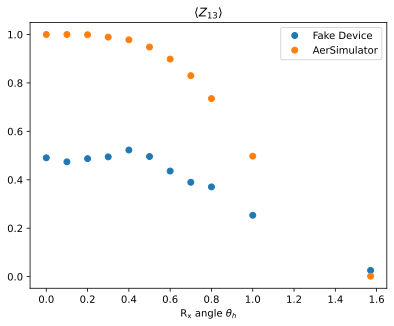

In [31]:
plt.plot(angles, result_fake[0].data.evs, "o", label="Fake Device")
plt.plot(angles, result_sim[0].data.evs, "o", label="AerSimulator")
plt.xlabel("$\\mathrm{R_x}$ angle $\\theta_h$")
plt.title("$\\langle Z_{13} \\rangle$")
plt.legend()
plt.show()

## 5. 127量子ビットのバージョンで問題を解く

最初に述べましたとおり、ユーティリティー・スケールの実験を実行することが今回の目標です。127量子ビットと 60レイヤー (20トロッター・ステップ)の規模を持ち、$\langle Z_{62} \rangle$をオブザーバブルとして用いた回路を構築して実行してみてください。先に実演した 27量子ビットのバージョンを参考にご自分で実際に試されることをお勧めしますが、以下に解を掲載します。

**解:**



### 5.1 ステップ 1: Map



In [ ]:
# backend_map = service.backend("ibm_kyiv")
backend_map = service.least_busy(operational=True, simulator=False)

num_steps = 20
qc = get_utility_circuit(backend_map, num_steps)
obs = SparsePauliOp.from_sparse_list(
    [("Z", [62], 1)], num_qubits=backend_map.num_qubits
)  # Eagle
angles = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0, np.pi / 2]

### 5.2 ステップ 2 および 3: Optimize と execute

参考までに、Eagleプロセッサーのカップリング・マップには 144個のエッジがあります。



In [ ]:
# backend = service.backend("ibm_kyiv")
backend = backend_map

transpiled_qc = transpile(qc, backend, optimization_level=1, layout_method="trivial")
transpiled_obs = obs.apply_layout(layout=transpiled_qc.layout)

print(get_circuit_info(qc, reps=1))
print(get_circuit_info(transpiled_qc))

In [ ]:
params = [[p] for p in angles]
estimator = Estimator(mode=backend)
pub = (transpiled_qc, transpiled_obs, params)
job = estimator.run([pub])

job_id = job.job_id()
print(f"job id={job_id}")

### 5.3 ステップ 4: Post-process

比較のために下のコードでは、エラー緩和手法を用いてユーティリティー論文で計算された図4bの "mitigated"ポイントの値を定数としてハードコードして与えています。ご自身の実験結果とあわせてプロットしてみてください。


In [ ]:
result_paper = [
    1.0171,
    1.0044,
    0.9563,
    0.9602,
    0.8394,
    0.8120,
    0.5466,
    0.4556,
    0.1953,
    0.0141,
    0.0117,
]

# REPLACE WITH YOUR OWN JOB ID
job = service.job(job_id)

plt.plot(angles, job.result()[0].data.evs, "o", label=f"{job.backend().name}")
plt.plot(angles, result_paper, "o", label="Utility Paper")
plt.xlabel("$\\mathrm{R_x}$ angle $\\theta_h$")
plt.title("$\\langle Z_{62} \\rangle$")
plt.legend()
plt.show()

自分で計算して得られた結果は図4bの "unmitigated"の点と似たような結果になりましたでしょうか。回路を実行したデバイスの特性と、その時の条件によってはだいぶ違った結果になることもあります。ですので、結果自体にはあまりこだわらないでいただきたいと思います。大事なのはコーディングが正しくできたかどうかです。もしうまくできたようであれば、ユーティリティー時代へのスタートラインに立てたということになりますので、ようこそ！と歓迎させていただきます。

ユーティリティー論文にも見られますように、今、世界中の科学者たちが、量子優位性を目指して、ノイズが存在する量子コンピューターの上でも価値ある結果が得られるように様々な工夫をしています。量子優位性とは、産業界の実用的な問題に対して、量子コンピューターが速度、信頼性、あるいは費用効率の点で古典コンピューターを超える解を提供できるようになった状態のことを指します。量子優位性はいちどきに起こる現象ではなくて、量子コンピューターの計算結果を古典コンピューターで再現しようとすると次第に長い時間がかかるようになっていって、ついには量子コンピューターで得られるリードタイムが重要な価値を持つようになっていく、という、ある程度の時間的長さを持った「時代 / 時期」を表す言葉と考えた方がよいかもしれません。量子優位性についてひとつ明らかなことは、そこに到達するためにはユーティリティー・スケールの実験を繰り返さなければいけないということです。今回のレッスンをご体験くださった皆様にとって、このレッスンが楽しく、そして適度に難しいものであって、そして量子優位性への冒険に皆様が踏み出すきっかけになっていれば、幸いです。



## Reference

*   Kim, Y., Eddins, A., Anand, S. et al. Evidence for the utility of quantum computing before fault tolerance. Nature 618, 500–505 (2023). [https://doi.org/10.1038/s41586-023-06096-3](https://doi.org/10.1038/s41586-023-06096-3)



© IBM Corp., 2017-2025